## <h2 style='text-align: center;'> **Metropolis-Hastings Markov Chain Monte Carlo (MCMC) method </br> with Bayesian inference on Damped Harmonic Oscillator** </h2> 
#### <p style='text-align: center;'> **author: Dr. V. Kalinova, Forschungszentrum Jülich @ Machine Learning Workshop (Cologne), September 27-28, 2024**
#### <p style='text-align: center;'> Based on the article <A Href="https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.1903K/abstract"> Kalinova et. al. 2017a </A> </p>

##### **Import packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import scipy.stats as ss  # For the priors (uniform and normal distributions)
import os

##### **Define the model for the damped harmonic oscillator**

In [2]:
def damped_oscillator_model(t, A, gamma, omega, phi):
    return A * np.exp(-gamma * t) * np.cos(omega * t + phi)

##### **Generate synthetic data**

In [3]:
np.random.seed(42)
N = 100  # Number of data points
T = np.linspace(0, 10, N)  # Time values

# True parameters
A_true = 1.0      # Amplitude
gamma_true = 0.1  # Damping coefficient
omega_true = 2.0 * np.pi  # Angular frequency (1 Hz)
phi_true = 0.0    # Phase

##### **Simulate the true model with some noise (measured displacement values)**

In [4]:
x_true = damped_oscillator_model(T, A_true, gamma_true, omega_true, phi_true)
noise_scale = 0.15
x_noisy = x_true + noise_scale * np.random.randn(N)

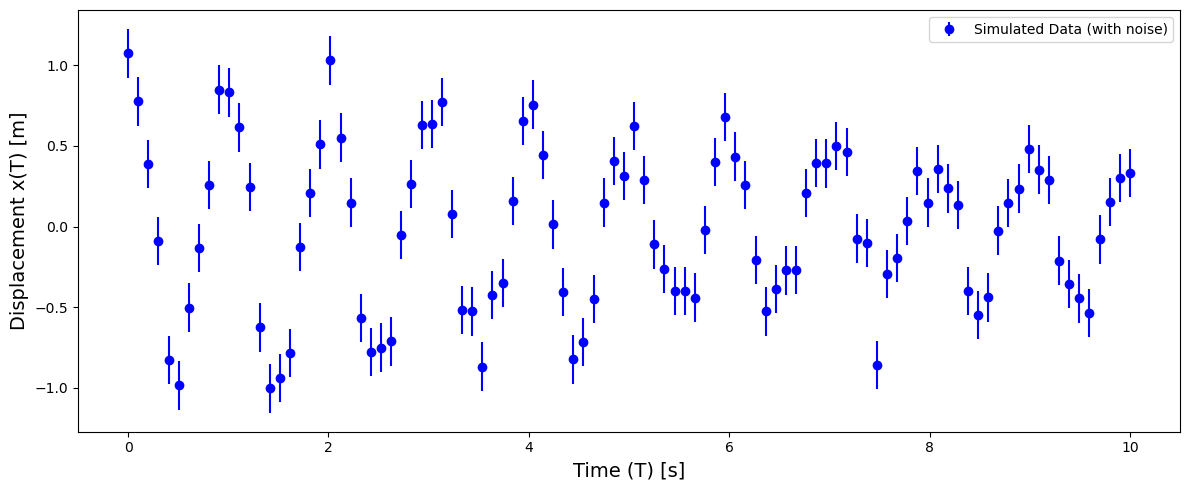

In [5]:
# Plot the data and the model with error bars
plt.figure(figsize=(12, 5))
plt.errorbar(T, x_noisy, yerr=noise_scale, fmt="o", label="Simulated Data (with noise)", color="blue")
plt.xlabel("Time (T) [s]", fontsize=14)
plt.ylabel("Displacement x(T) [m]", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

##### **Define the log probability function, combining likelihood and priors**

In [6]:
def log_prob(theta, t, x, noise_scale, A_in, gamma_in, omega_in, phi_in):
    A, gamma, omega, phi = theta
    
    # Priors (Uniform and Normal)
    prior_A = ss.uniform.logpdf(A, loc=0, scale=10) + ss.norm.logpdf(A, loc=A_in, scale=0.5)
    prior_gamma = ss.uniform.logpdf(gamma, loc=0, scale=1) + ss.norm.logpdf(gamma, loc=gamma_in, scale=0.1)
    prior_omega = ss.uniform.logpdf(omega, loc=0, scale=10) + ss.norm.logpdf(omega, loc=omega_in, scale=0.5)
    prior_phi = ss.uniform.logpdf(phi, loc=-np.pi, scale=2*np.pi) + ss.norm.logpdf(phi, loc=phi_in, scale=0.1)
    
    # Check if the priors are finite
    if not np.isfinite(prior_A + prior_gamma + prior_omega + prior_phi):
        return -np.inf

    # Likelihood: comparing the model to the data
    model = damped_oscillator_model(t, A, gamma, omega, phi)
    likelihood = -0.5 * np.sum(((x - model) / noise_scale) ** 2)

    # Return log posterior (sum of log likelihood and log priors)
    return likelihood + prior_A + prior_gamma + prior_omega + prior_phi

##### **Set the number of walkers and dimensions**

In [7]:
ndim, nwalkers = 4, 32    #the number of the walkers is at least twice the number of dimensions

##### **Seed the walkers**

In [8]:
def seed_walkers(nwalkers, A_in, gamma_in, omega_in, phi_in):
    p0 = np.zeros((nwalkers, ndim))
    p0[:, 0] = np.random.randn(nwalkers) * 0.5 + A_in       # Amplitude A
    p0[:, 1] = np.random.uniform(0, 1, nwalkers)            # Damping coefficient gamma
    p0[:, 2] = np.random.randn(nwalkers) * 0.5 + omega_in   # Angular frequency omega
    p0[:, 3] = np.random.randn(nwalkers) * 0.1 + phi_in     # Phase phi
    return p0

##### **Initial parameter guesses (seeding the walkers)** 

In [9]:
p0 = seed_walkers(nwalkers, A_true, gamma_true, omega_true, phi_true)

##### **Define burn-in and final steps**

In [10]:
burn_steps = 500
final_steps = 2000

##### **Create the sampler**

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(T, x_noisy, noise_scale, A_true, gamma_true, omega_true, phi_true))

##### **MCMC Burn-in Phase**

In [12]:
print("Running Burn-in phase...")
sampler.run_mcmc(p0, burn_steps, progress=True)

# Save burn-in chains
burn_in_chains = sampler.get_chain()
burn_in_lnprob = sampler.get_log_prob()

# Reset the sampler to discard burn-in phase
sampler.reset()

Running Burn-in phase...


100%|█████████████████████████████████████████| 500/500 [00:23<00:00, 21.02it/s]


##### **MCMC Posterior Phase (after burn-in)**

In [13]:
print("Running final posterior MCMC phase after burn-in...")
sampler.run_mcmc(burn_in_chains[-1], final_steps, progress=True)

# Extract the final samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)

Running final posterior MCMC phase after burn-in...


100%|███████████████████████████████████████| 2000/2000 [01:35<00:00, 20.87it/s]


##### **Calculating the error percentiles**

In [14]:
# Compute percentiles (16th, 50th, 84th) for each parameter
medians = np.percentile(samples, 50, axis=0)
percentiles = np.percentile(samples, [16, 50, 84], axis=0)
errors = np.diff(percentiles, axis=0)

# Print the results with error bars
labels = ["Amplitude (A)", "Damping (gamma)", "Omega (ω)", "Phase (phi)"]
for i in range(ndim):
    print(f"{labels[i]} = {percentiles[1, i]:.3f} +{errors[1, i]:.3f} -{errors[0, i]:.3f}")


# Compute the model with the median values and the uncertainty ranges
x_best_fit = damped_oscillator_model(T, *medians)
x_samples = np.array([damped_oscillator_model(T, *theta) for theta in samples[np.random.randint(len(samples), size=100)]])

# 1-sigma (16th to 84th percentile) uncertainty range
x_lower_1sigma = np.percentile(x_samples, 16, axis=0)
x_upper_1sigma = np.percentile(x_samples, 84, axis=0)

# 3-sigma (0.3th to 99.7th percentile) uncertainty range
x_lower_3sigma = np.percentile(x_samples, 0.3, axis=0)
x_upper_3sigma = np.percentile(x_samples, 99.7, axis=0)

Amplitude (A) = 1.026 +0.053 -0.047
Damping (gamma) = 0.100 +0.012 -0.011
Omega (ω) = 6.281 +0.011 -0.011
Phase (phi) = -0.000 +0.046 -0.045


##### **Plot the burn-in and posterior chains for all parameters**

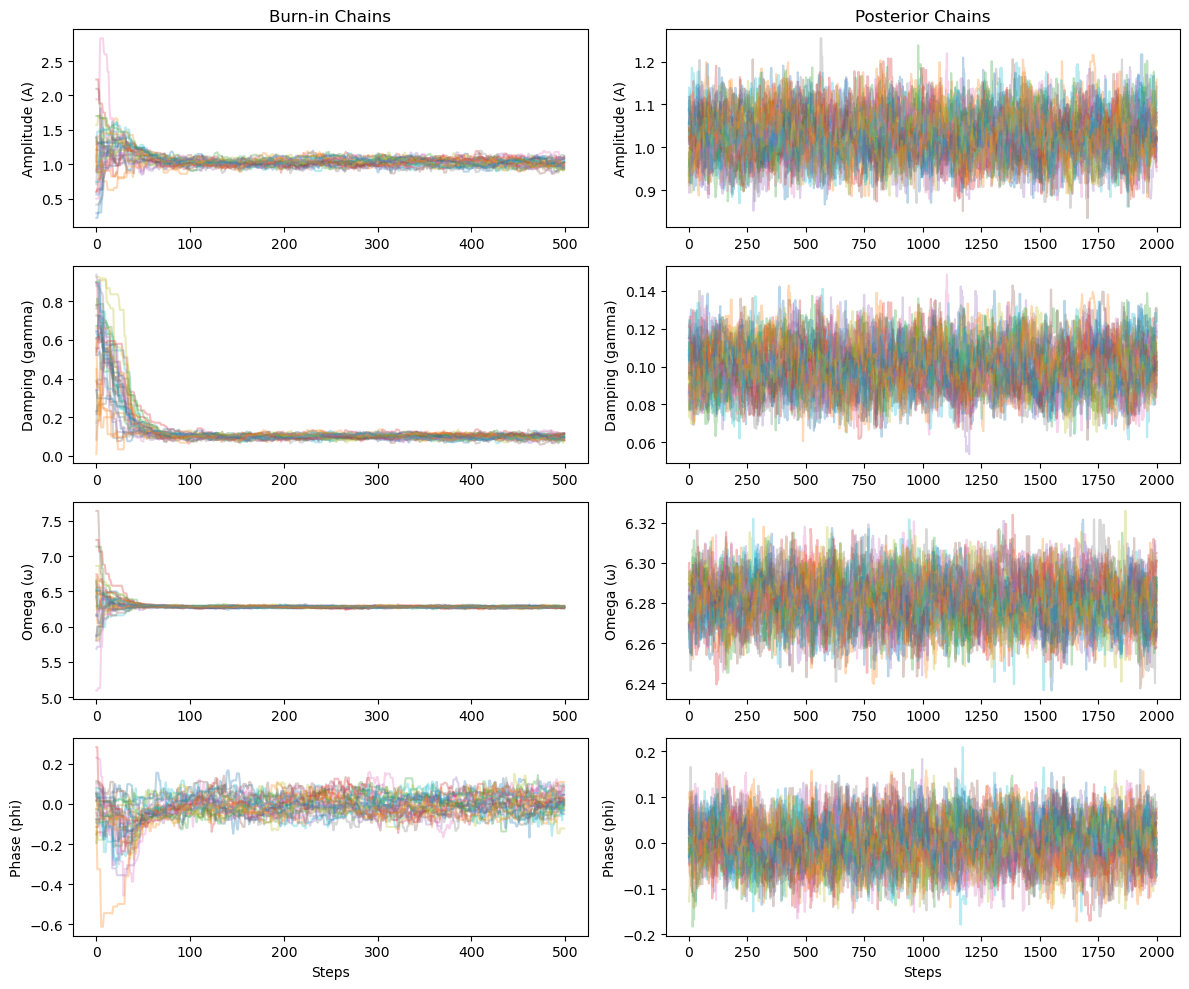

In [15]:
# Plot the burn-in and posterior chains for all parameters
fig, axes = plt.subplots(ndim, 2, figsize=(12, 10))

for i in range(ndim):
    # Burn-in chain for each parameter
    axes[i, 0].plot(burn_in_chains[:, :, i], alpha=0.3)
    axes[i, 0].set_ylabel(labels[i])
    if i == 0:
        axes[i, 0].set_title("Burn-in Chains")
    
    # Posterior chain for each parameter
    final_chains = sampler.get_chain()
    axes[i, 1].plot(final_chains[:, :, i], alpha=0.3)
    if i == 0:
        axes[i, 1].set_title("Posterior Chains")
    axes[i, 1].set_ylabel(labels[i])

axes[-1, 0].set_xlabel("Steps")
axes[-1, 1].set_xlabel("Steps")

plt.tight_layout()
plt.show()

##### **Plot the corner plot with median values and percentiles**

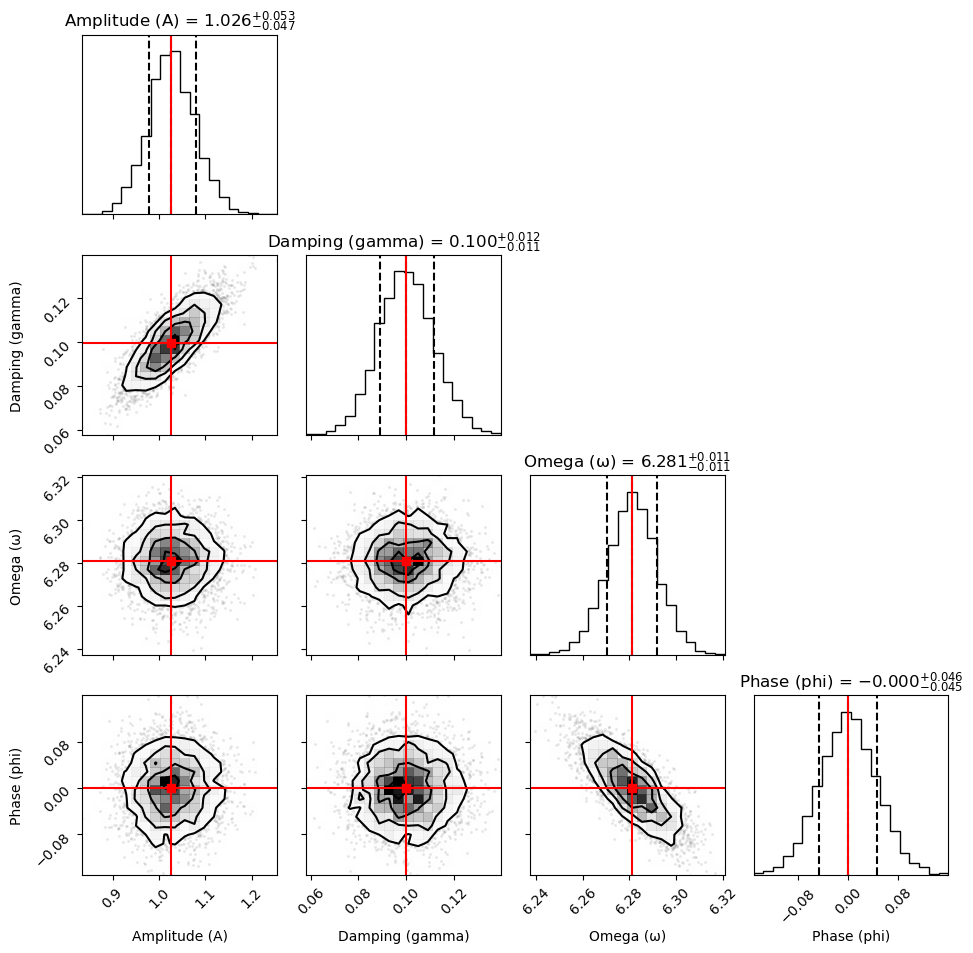

In [16]:
fig = corner.corner(samples,labels=labels,show_titles=True,
    title_fmt=".3f",quantiles=[0.16, 0.5, 0.84],title_kwargs={"fontsize": 12},
    truths=percentiles[1],truth_color="red")

plt.tight_layout()
plt.show()

##### **Final Plot presenting the synthetic data and the model with the corresponding uncertainties**

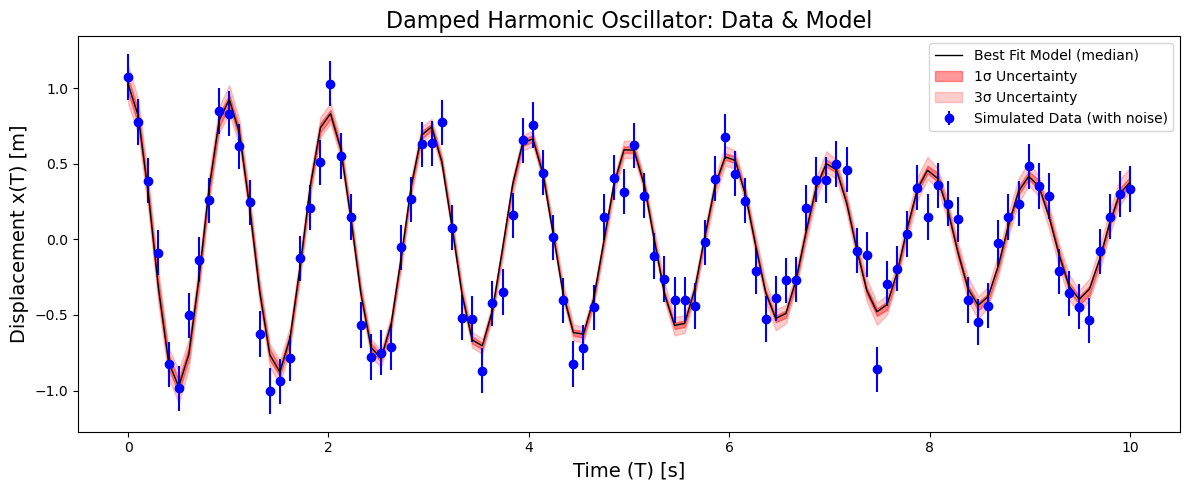

In [17]:
plt.figure(figsize=(12, 5))

# First panel: Plot x(T) vs T with 1-sigma and 3-sigma uncertainty ranges
plt.errorbar(T, x_noisy, yerr=noise_scale, fmt="o", label="Simulated Data (with noise)", color="blue")

# Plot best fit and uncertainty ranges
plt.plot(T, x_best_fit, label="Best Fit Model (median)", color="k", lw=1)
plt.fill_between(T, x_lower_1sigma, x_upper_1sigma, color="red", alpha=0.4, label="1σ Uncertainty")
plt.fill_between(T, x_lower_3sigma, x_upper_3sigma, color="red", alpha=0.2, label="3σ Uncertainty")
plt.xlabel("Time (T) [s]", fontsize=14)
plt.ylabel("Displacement x(T) [m]", fontsize=14)
plt.title("Damped Harmonic Oscillator: Data & Model", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

 <p style='text-align: center;' > all rights reserved </p>